In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    W_out = W.copy()
    indptr = W_out.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W_out.data[last_idx:idx] *= x[col_id]
            last_idx = idx
    return W_out

In [5]:
# Problem 4(a).
# TODO: coordinate descent of lasso, note lmda stands for lambda
def calculate_cost(X, w, w0, y, lmda):
    cost = np.dot(X,w)
    cost = cost + w0*np.ones(cost.shape) - y
    cost = cost**2
    total_cost = np.sum(cost)
    total_cost = total_cost/2
    total_cost = total_cost + lmda*np.sum(np.abs(w))
    #print("Total Cost : ", total_cost)
    return total_cost

def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    num_samples, num_features = X.shape
    #print(X.shape)
    w, w0 = Initialw(X,y)
    Cost = []
    prev_w = 100000*np.ones(w.shape)
    step = 0
    while((np.max(np.abs(w - prev_w)) > epsilon) and step <= 100):
        for i in range(w.size):
            prev_w[i] = w[i]
        for k in range(num_features):
            Xtheta_wok = np.zeros(num_samples)
            temp_w = np.zeros(w.shape)
            temp_w = w
            w[k] = 0
            Xtheta_wok = np.matmul(X,temp_w)
            R_k = y - Xtheta_wok
            C_total = np.sum(np.dot(R_k,X[:,k]))
            A_total = np.sum(np.dot(X[:,k],X[:,k]))
            if C_total < -lmda :
                w[k] = (C_total + lmda)/A_total
            elif C_total > lmda :
                w[k] = (C_total - lmda)/A_total
            else:
                w[k] = 0
        current_cost = calculate_cost(X, w, w0, y, lmda)
        Cost.append(current_cost)
        step += 1
    return (w,w0,Cost)

In [6]:
# Problem 4(a): data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

[ 9.53051744 -9.4689961  -9.47056747  9.4387061   9.58339615  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.14519184  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


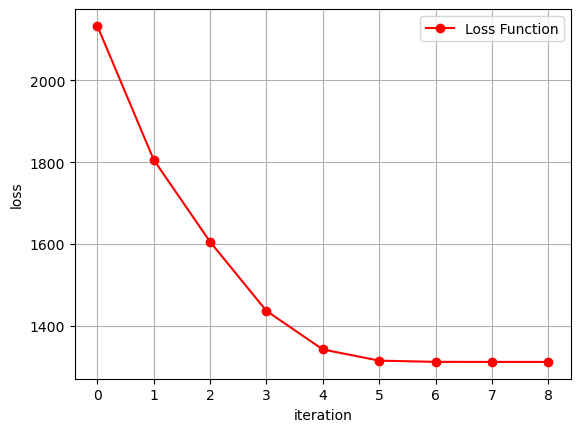

In [7]:
# Problem 4(a): run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso, Cost = lasso(X, y, lmda = 25.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
plt.plot(Cost, c = 'red', ls = '-', marker = 'o', label = 'Loss Function')
plt.grid()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
print(w_lasso)

In [8]:
# Problem 4(b):
def root_mean_square_error(pred, y):
    diff_matrix = y - pred
    rmse = diff_matrix**2
    rmse = rmse.sum()
    rmse = rmse/np.size(y)
    rmse = np.sqrt(rmse)
    return rmse

def Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true):
    numerator = 0
    precision_dec = 0
    recall_dec = 0
    for i in range(w_true.size):
        if((w_true[i] != 0) and (w_lasso[i] != 0)):
            numerator += 1
        if(w_true[i] != 0):
            recall_dec += 1
        if(w_lasso[i] != 0):
            precision_dec += 1
    precision_w = 0
    if precision_dec != 0 :
        precision_w = numerator/precision_dec
    recall_w = numerator/recall_dec
    sparsity_w = precision_dec
    pred = np.dot(X,w_lasso) 
    rmse = root_mean_square_error(pred, y)
    return (rmse, sparsity_w, precision_w, recall_w)

In [9]:
# Problem 4(b)
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
(rmse, sparsity_w, precision_w, recall_w) = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print("Precision : ", precision_w)
print("Recall :", recall_w)
print("Sparsity :", sparsity_w)
print("Root Mean Square Error :", rmse)

Precision :  0.8333333333333334
Recall : 1.0
Sparsity : 6
Root Mean Square Error : 1.401209192235464


In [10]:
# Problem 4(c), first part
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    y_av = np.mean(y)
    num_samples, num_features = X.shape
    y_norm = y - y_av*np.ones(y.shape)
    lmdaMax = np.max(np.abs(np.dot(y_norm,X)))
    lmdaMin = 0
    Lmda = np.linspace(lmdaMin, lmdaMax, 50)
    #print(Lmda)
    W = []
    W0 = []
    for l in Lmda:
        w_lasso, w0_lasso, Cost = lasso(X, y, l, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
        W.append(w_lasso)
        W0.append(w0_lasso)
    cl = ['red', 'blue']
    #print("Start plotting")
    for i in range(num_features-5):
        temp = np.zeros(50)
        for j in range(50):
            temp[j] = W[j][i+5]
        plt.plot(Lmda, temp, cl[1], ls = '-', marker = 'o')
    for i in range(5):
        temp = np.zeros(50)
        for j in range(50):
            temp[j] = W[j][i]
        plt.plot(Lmda, temp, cl[0], ls = '-', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda Values')
    plt.ylabel('Weights\n (Non-zero features = red\n, Zero = blue)')
    return (W, W0, Lmda)

In [11]:
# Problem 4(c), second part:
# TODO: create function to evaluate a given lasso solution path & draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    Precision = []
    Recall = []
    Sparsity = []
    RMSE = []
    for l in range(50) :
        (rmse, sparsity_w, precision_w, recall_w) = Evaluate(X, y, W[l], W0[l], w_true, w0_true)
        Precision.append(precision_w)
        Recall.append(recall_w)
        Sparsity.append(sparsity_w)
        RMSE.append(rmse)
    cl = ['red', 'blue']
    plt.plot(Lmda, Precision, cl[0], ls = '-', marker = 'o', label = 'Precision')
    plt.plot(Lmda, Recall, cl[1], ls = '-', marker = 'o', label = 'Recall')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda Values')
    plt.ylabel('Precision and Recall Graphs')
    return (RMSE, Sparsity, Precision, Recall)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


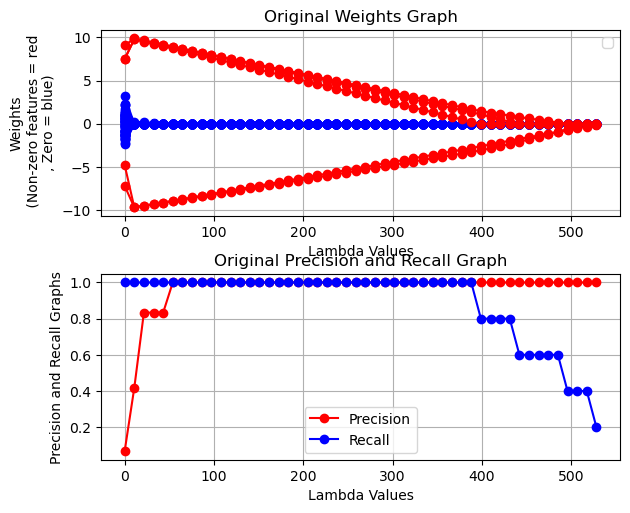

In [12]:
plt.subplot(2,1,1)
plt.gca().set_title('Original Weights Graph')
W, W0, Lmda = LassoPath(X, y)
plt.tight_layout()
plt.subplot(2,1,2)
plt.gca().set_title('Original Precision and Recall Graph')
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


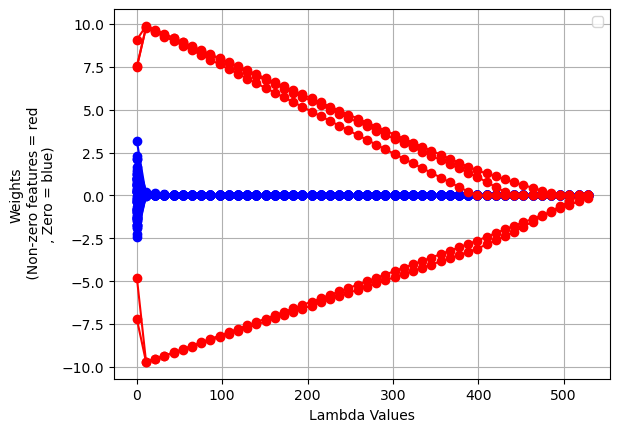

In [13]:
# Problem 4(c), third part:
# TODO: using the above, draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


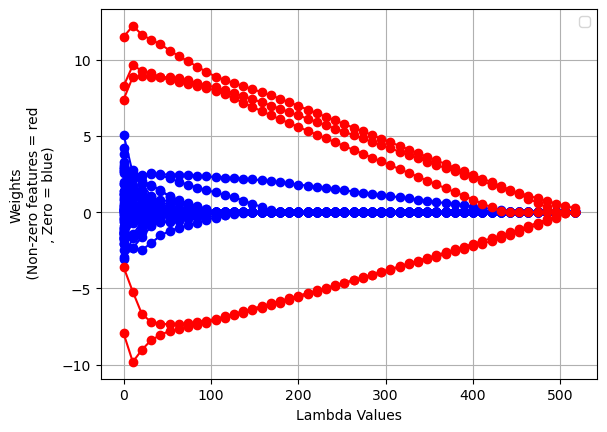

In [14]:
# Problem 4(c), noise standard deviation:
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
W, W0, Lmda = LassoPath(X, y)

n =  50  m =  75


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n =  50  m =  150


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n =  50  m =  1000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n =  100  m =  75


/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_17115/3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n =  100  m =  150


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n =  100  m =  1000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


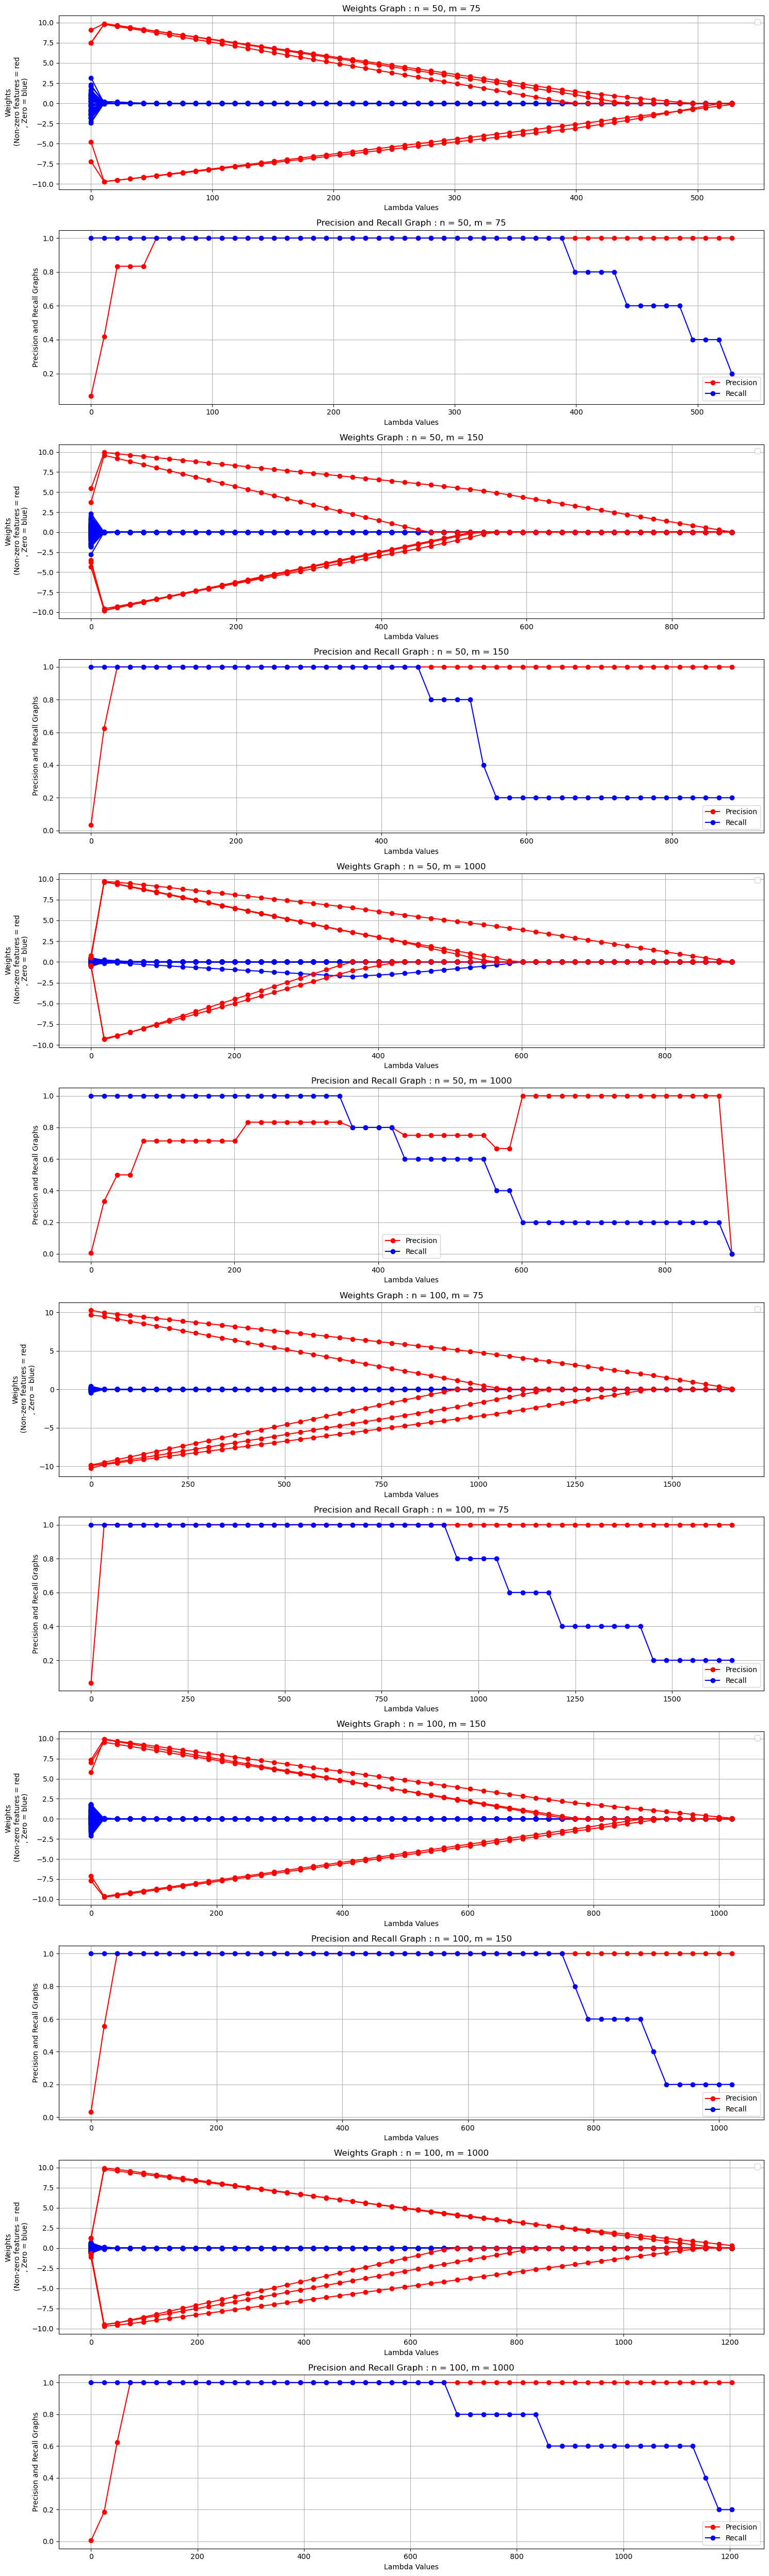

In [15]:
# Problem 4(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
n = [50, 50, 50, 100, 100, 100]
m = [75, 150, 1000, 75, 150, 1000]
#n = [50]
#m = [75]
plt.subplots(12,1,figsize=(15,50))
for i in range(6):
    print("n = ", n[i], " m = ", m[i])
    X, y, w_true, w0_true = DataGenerator(n=n[i], d=m[i], k=5, sigma=1.0)
    plt.subplot(12,1,2*i+1)
    W, W0, Lmda = LassoPath(X, y)
    plt.gca().set_title('Weights Graph : n = ' + str(n[i]) + ', m = ' + str(m[i]))
    plt.tight_layout()
    plt.subplot(12,1,2*i+2)
    RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
    plt.gca().set_title('Precision and Recall Graph : n = ' + str(n[i]) + ', m = '+ str(m[i]))
    plt.tight_layout()

In [16]:
# Problem 4(e): predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 30000, valid_size = 5000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [17]:
# Problem 4(e): predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots

# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMulKthColumnWithVector(W, x, k):
    indptr = W.indptr
    sum = 0
    print(x.shape)
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            if col_id == k:  
                sum += (W.data[last_idx:idx]*x[col_id])
            last_idx = idx
    return sum
    
def lasso_sparse(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    num_samples, num_features = X.shape
    #print(X.shape)
    w, w0 = Initialw(X,y)
    prev_w = np.zeros(num_features)
    step = 0
    while((np.max(np.abs((w - prev_w))) > epsilon) and step <= max_iter):
        prev_w = w.copy()
        #print(w)
        for k in range(num_features):
            temp_w = np.zeros(w.shape)
            temp_w = w
            temp_w[k] = 0
            #print(temp_w.shape)
            Xtheta_wok_sparse = cscMatInplaceEleMultEveryRow(X,temp_w)
            Xtheta_wok = Xtheta_wok_sparse.sum(axis=1)
            #print(Xtheta_wok.shape)
            ynp = np.expand_dims(y, axis=-1)
            #print(ynp.shape)
            R_k = ynp - Xtheta_wok
            #print(R_k.shape)
            #print("Subtraction done")
            X_k = X.getcol(k)
            #print(X_k.shape)
            C_total = X_k.T.dot(R_k).sum(axis=0)
            #print(C_total)
            A_total = X_k.power(2).sum()
            #print(A_total)
            if C_total < -lmda :
                w[k] = (C_total + lmda)/A_total
            elif C_total > lmda :
                w[k] = (C_total - lmda)/A_total
            else:
                w[k] = 0
        #print(w.shape)
        #print(w)
        step += 1
    #print(w)
    return (w,w0)

def root_mean_square_error(pred, y):
    ynp = np.expand_dims(y, axis=-1)
    diff_matrix = sparse.csc_matrix(ynp) - pred
    #if sparse.issparse(diff_matrix) :
        #print(diff_matrix.shape)
    rmse = diff_matrix.power(2).sum()
    rmse = rmse/np.size(y)
    rmse = np.sqrt(rmse)
    return rmse

def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    y_av = np.mean(y_train)
    y_norm = y_train - y_av
    lmdaMax = np.max(np.abs(X_train.T.dot(y_norm)))
    #print(lmdaMax)
    lmdaMin = 0.1*lmdaMax
    num_samples, num_features = X_train.shape
    noOfLambas = 20
    Lmda = np.linspace(lmdaMin, lmdaMax, noOfLambas)
    w_lasso = []
    TrainingRMSEs = []
    ValidationRMSEs = []
    for l in Lmda :
        print("Starting Lambda : " + str(l))
        (w,w0) = lasso_sparse(X_train, y_train, l, epsilon = 1.0e-2, draw_curve = True, max_iter = 50)
        #print("Sparse Lasso Done")
        w_lasso.append(w)
        #print("RMSE started")
        trainingPred = sparse.csc_array(cscMatInplaceEleMultEveryRow(X_train,w).sum(axis=1))
        #if sparse.issparse(trainingPred) :
            #print(trainingPred.shape)
        trainingRmse = root_mean_square_error(trainingPred,y_train)
        TrainingRMSEs.append(trainingRmse)
        #print("Training Set stuff done")
        validationPred = sparse.csc_array(cscMatInplaceEleMultEveryRow(X_valid,w).sum(axis=1))
        validationRmse = root_mean_square_error(validationPred,y_valid)
        ValidationRMSEs.append(validationRmse)
        #print("RMSE done")
    plt.subplots(3,1,figsize=(10,30))
    cl = ['red']
    plt.subplot(3,1,1)
    #print("Start plotting")
    for i in range(num_features):
        temp = np.zeros(noOfLambas)
        for j in range(noOfLambas):
            temp[j] = w_lasso[j][i]
        plt.plot(Lmda, temp, cl[0], ls = '-', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda Values')
    plt.ylabel('Weights')
    plt.subplot(3,1,2)
    #print("Start plotting")
    temp = np.zeros(noOfLambas)
    for j in range(noOfLambas):
        temp[j] = TrainingRMSEs[j]
    plt.plot(Lmda, temp, cl[0], ls = '-', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda Values')
    plt.ylabel('Training RMSE')
    plt.subplot(3,1,3)
    #print("Start plotting")
    temp = np.zeros(noOfLambas)
    for j in range(noOfLambas):
        temp[j] = ValidationRMSEs[j]
    plt.plot(Lmda, temp, cl[0], ls = '-', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Lambda Values')
    plt.ylabel('Validation RMSE')
    minIndex = ValidationRMSEs.index(min(ValidationRMSEs))
    lmda_best_index = minIndex
    lmda_best = Lmda[minIndex]
    print("The best Lambda as per our evaulation is " + str(lmda_best))
    print("Validation Set RMSE : " + str(ValidationRMSEs[minIndex]))
    print("Training Set RMSE : " + str(TrainingRMSEs[minIndex]))
    return (w_lasso, w0_lasso, lmda_best, lmda_best_index)

Starting Lambda : 3.957825401364829
Starting Lambda : 5.832584802011327
Starting Lambda : 7.707344202657826
Starting Lambda : 9.582103603304322
Starting Lambda : 11.456863003950822
Starting Lambda : 13.331622404597319
Starting Lambda : 15.206381805243817
Starting Lambda : 17.081141205890315
Starting Lambda : 18.955900606536815
Starting Lambda : 20.83066000718331
Starting Lambda : 22.705419407829808
Starting Lambda : 24.580178808476308
Starting Lambda : 26.454938209122805
Starting Lambda : 28.329697609769305
Starting Lambda : 30.2044570104158
Starting Lambda : 32.079216411062305
Starting Lambda : 33.9539758117088
Starting Lambda : 35.8287352123553
Starting Lambda : 37.703494613001794
Starting Lambda : 39.57825401364829


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The best Lambda as per our evaulation is 5.832584802011327
Validation Set RMSE : 2.5518993445640437
Training Set RMSE : 2.4524218415861774
Testing Set RMSE : 2.603536820441196
Lasso select features:
the 344.1678544194271
and 238.00036897092048
dog food worst -115.99833178262747
the people -98.24193726466952
sometime -75.03374864214545
great 66.8468434285838
soaked -63.99805264776684
were -36.18642115055025
sure the -35.76581601794429
best 33.32704433594598


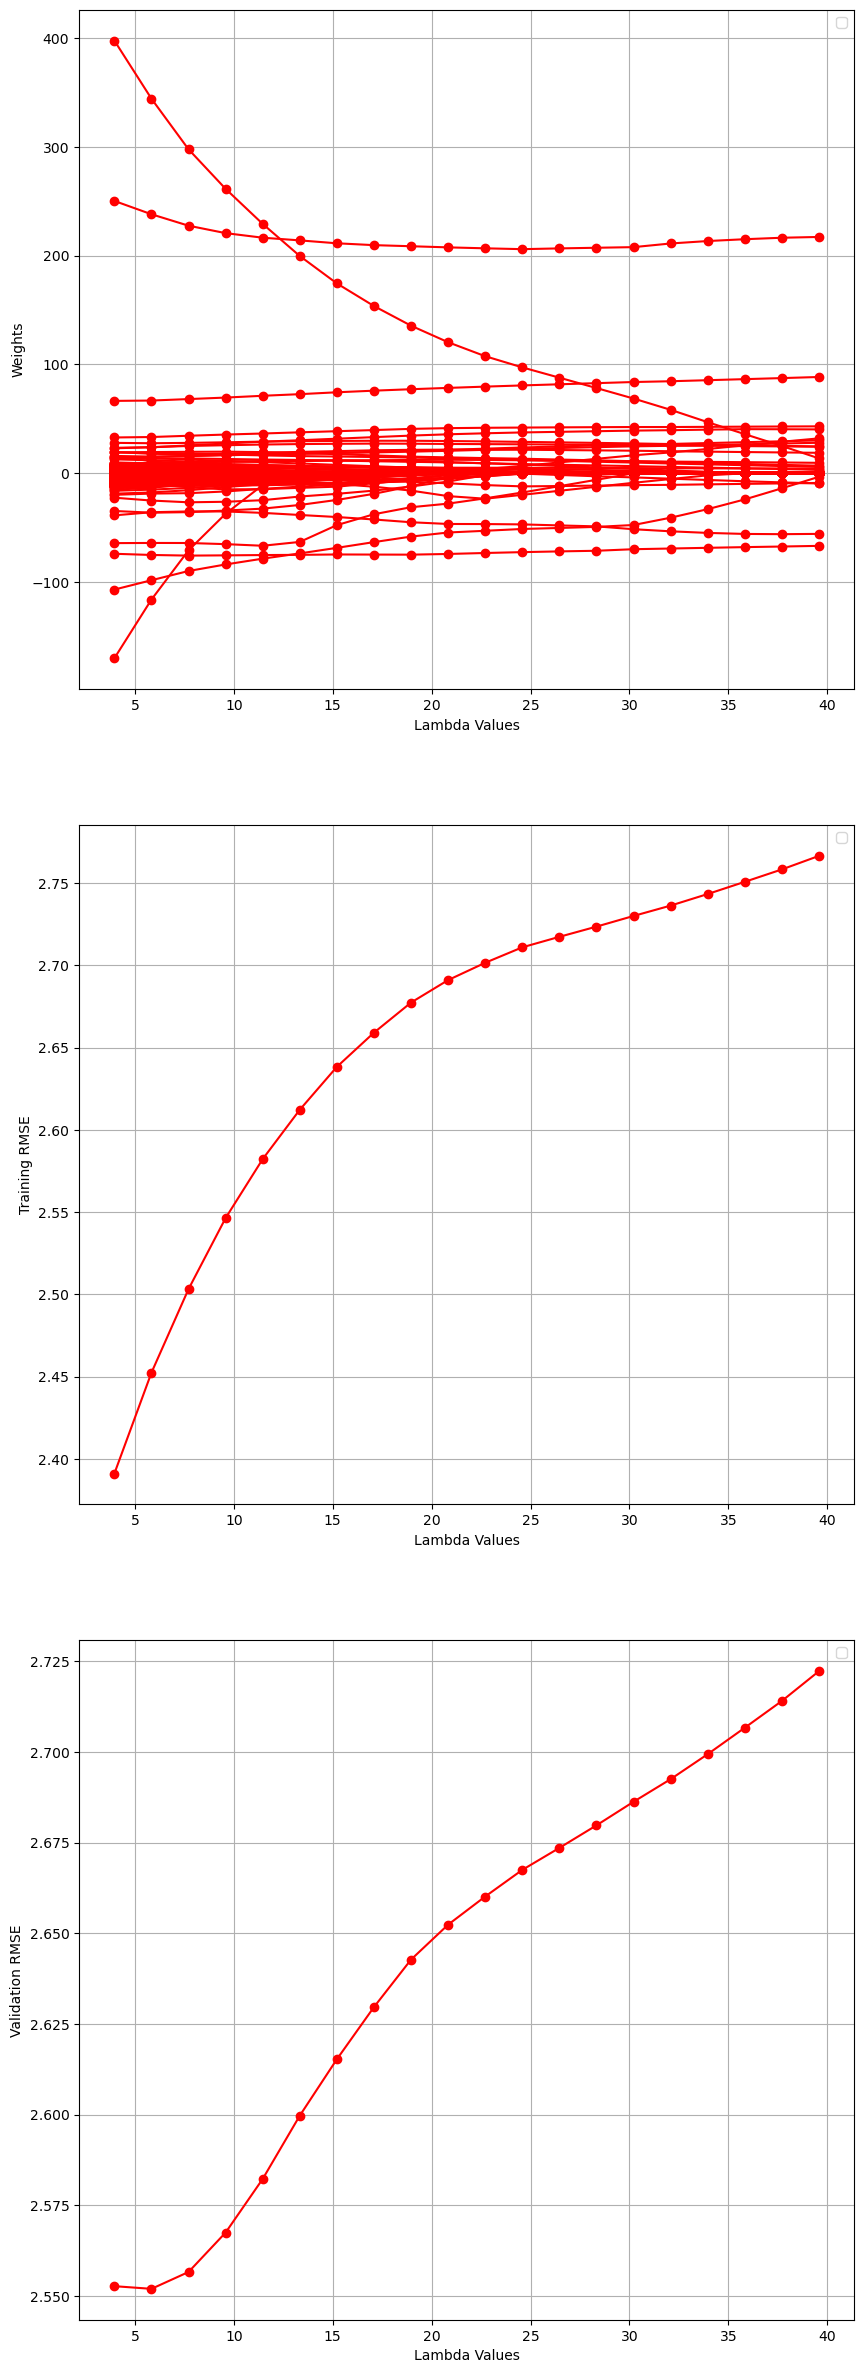

In [18]:
# Problem 4(e): predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)

# evaluation
w_lasso, w0_lasso, lmda_best, lmda_best_index = Validation(X_train, y_train, X_valid, y_valid)

testingPred = sparse.csc_array(cscMatInplaceEleMultEveryRow(X_test,w_lasso[lmda_best_index]).sum(axis=1))
testingRmse = root_mean_square_error(testingPred,y_test)
print("Testing Set RMSE : " + str(testingRmse))

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso[lmda_best_index])).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[lmda_best_index][idx[i]])